In [ ]:
import torch
import numpy as np
from utils import Normalizer, set_seed
from utils.conditional_Action_DiT import Conditional_ODE
import matplotlib.pyplot as plt
from utils.discrete import *
import sys
import pdb
import csv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
n_gradient_steps = 100_000
batch_size = 64
model_size = {"d_model": 256, "n_heads": 4, "depth": 3}
H = 10 # horizon, length of each trajectory

# Define initial and final points, and a single central obstacle
initial_point_up = np.array([0.0, 0.0])
final_point_up = np.array([20.0, 0.0])
final_point_down = np.array([0.0, 0.0])
initial_point_down = np.array([20.0, 0.0])
obstacle = (10, 0, 4.0) 

# Loading training trajectories
all_points1 = []    # want modes 1, 2, 4, 6
all_points2 = []    # want modes 1, 2, 3, 5
with open('data/trajs_noise1.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        x1, y1 = float(row[4]), float(row[5])
        x2, y2 = float(row[7]), float(row[8])
        all_points1.append([x1, y1])
        all_points2.append([x2, y2])



# Unspliced trajectories to get final positions
orig1 = [
    all_points1[i * 100:(i + 1) * 100]
    for i in range(1000)
]
orig2 = [
    all_points2[i * 100:(i + 1) * 100]
    for i in range(1000)
]
orig1 = np.array(orig1)
orig2 = np.array(orig2)

In [2]:
modes = []

for i in range(len(orig1)):
    traj1 = orig1[i]
    traj2 = orig2[i]
    if np.min(traj2[:, 1]) < -5:    # 6: Red goes very low
        modes.append(6)
    elif np.max(traj2[:, 1]) > 5:   # 5: Red goes very high
        modes.append(5)
    elif np.min(traj1[:, 1]) < -5:  # 4: Blue goes very low
        modes.append(4)
    elif np.max(traj1[:, 1]) > 5:   # 3: Blue goes very high
        modes.append(3)
    elif np.average(traj1[:, 1]) < np.average(traj2[:, 1]): # 2: Red goes up
        modes.append(2)
    elif np.average(traj1[:, 1]) > np.average(traj2[:, 1]): # 1: Blue goes up
        modes.append(1)
    else:
        print(i)

4


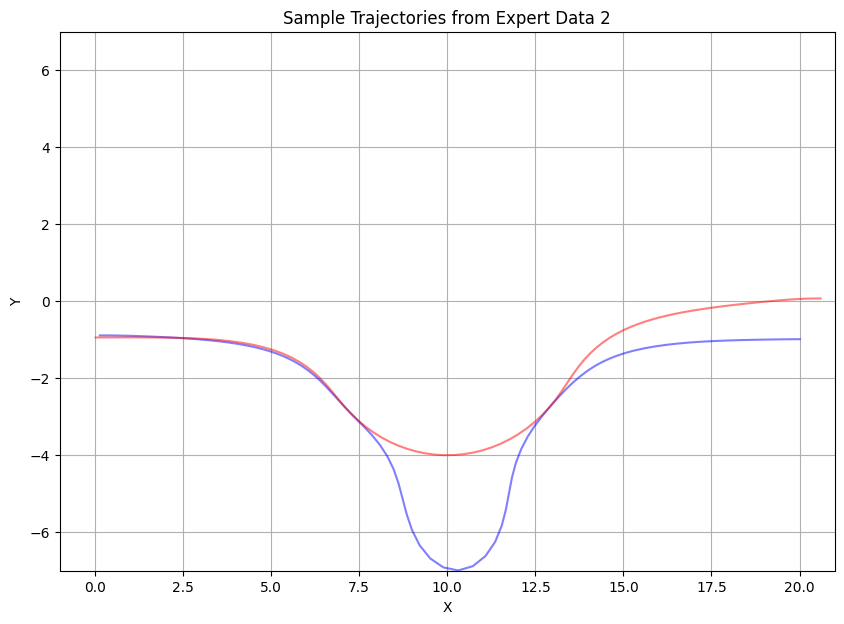

In [13]:
plt.figure(figsize=(10, 7))
i = 999
print(modes[i])
traj1 = np.array(orig1[i])
traj2 = np.array(orig2[i])
plt.plot(traj1[:, 0], traj1[:, 1], 'b-', alpha=0.5)
plt.plot(traj2[:, 0], traj2[:, 1], 'r-', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim([-1, 21])
plt.ylim([-7, 7])
plt.title('Sample Trajectories from Expert Data 2')
plt.grid(True)
plt.savefig("test.png")

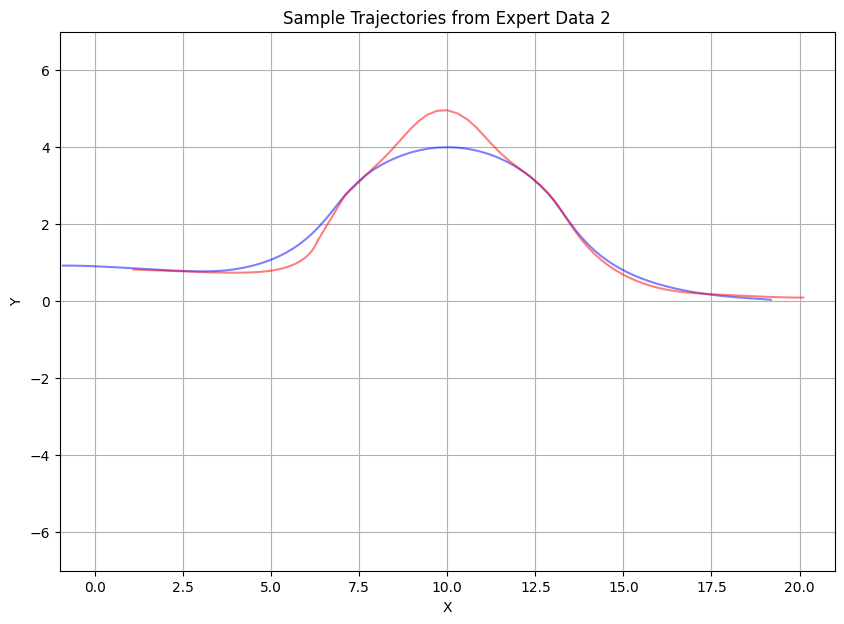

In [7]:
import torch
import numpy as np
from utils.conditional_Action_DiT import Conditional_ODE
import matplotlib.pyplot as plt
from utils.discrete import *
import sys
import pdb
import csv
from utils.mpc_util import reactive_mpc_plan, reactive_mpc_plan_guidesample

# Loading training trajectories
expert_data_1 = np.load('data/expert_data1_570_mpc.npy')
expert_data_2 = np.load('data/expert_data2_570_mpc.npy')

plt.figure(figsize=(10, 7))
i = 569
traj1 = expert_data_1[i]
traj2 = expert_data_2[i]
plt.plot(traj1[:, 0], traj1[:, 1], 'b-', alpha=0.5)
plt.plot(traj2[:, 0], traj2[:, 1], 'r-', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim([-1, 21])
plt.ylim([-7, 7])
plt.title('Sample Trajectories from Expert Data 2')
plt.grid(True)